# Deep Learning for Structured Data

## Introduction

In this lesson, we will use tensorflow and keras for deep learning using neural networks.

**Tensorflow** is an open-source, optimized tensor library for handling tensor-based operations. It serves as the back-end engine of **Keras**. An alternative option is **Theano**.

**Keras** is a neural network API (model-level library) written to run on top of Tensorflow. Keras provides the framework to define and train deep learning models.

A **deep neural network** is an artificial neural network (ANN) with multiple hidden layers between the input and output layers. 

The more hidden layers that we have in the network, the deeper the neural network can learn. Deep neural networks are usually made up of long chains of hidden layers. Deep learning models will typically have more hidden layers but less nodes per layer than the typical, more shallow ANN model. 



## Preliminary

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import keras
from keras import metrics
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras.layers import Conv1D, GlobalMaxPooling1D, Dropout, Dense, GRU, LSTM, Bidirectional
from keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

### Data Overview

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving equity_imp_bin.csv to equity_imp_bin.csv
User uploaded file "equity_imp_bin.csv" with length 470617 bytes


In [ ]:
equity_imp = pd.read_csv('equity_imp_bin.csv')

### Data Exploration

In [ ]:
equity_imp.head()

,Unnamed: 0,Loan_Amount,Mort_Bal,Home_Val,Reason_HE,YOJ,Num_Derog,Num_Delinq,CL_Age,Num_Inq,Num_CL,Debt_Inc,Default,Occupation.Mgr,Occupation.Office,Occupation.Other,Occupation.ProfExe,Occupation.Sales,Occupation.Self
0,1,1100,25860.0,39025.0,0,10.5,0,0,94.366667,1,9,40.564750,1,0,0,1,0,0,0
1,2,1300,70053.0,68400.0,0,7.0,0,2,121.833333,0,14,43.469263,1,0,0,1,0,0,0
2,3,1500,13500.0,16700.0,0,4.0,0,0,149.466667,1,10,36.878297,1,0,0,1,0,0,0
3,4,1500,97517.0,120000.0,0,1.0,1,5,102.500000,1,23,44.369171,1,0,0,1,0,0,0
4,5,1700,97800.0,112000.0,0,3.0,0,0,93.333333,0,14,35.810878,0,0,1,0,0,0,0


In [ ]:
equity_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962 entries, 0 to 5961
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          5962 non-null   int64  
 1   Loan_Amount         5962 non-null   int64  
 2   Mort_Bal            5962 non-null   float64
 3   Home_Val            5962 non-null   float64
 4   Reason_HE           5962 non-null   int64  
 5   YOJ                 5962 non-null   float64
 6   Num_Derog           5962 non-null   int64  
 7   Num_Delinq          5962 non-null   int64  
 8   CL_Age              5962 non-null   float64
 9   Num_Inq             5962 non-null   int64  
 10  Num_CL              5962 non-null   int64  
 11  Debt_Inc            5962 non-null   float64
 12  Default             5962 non-null   int64  
 13  Occupation.Mgr      5962 non-null   int64  
 14  Occupation.Office   5962 non-null   int64  
 15  Occupation.Other    5962 non-null   int64  
 16  Occupa

## Preprocessing & Transformation

This is already handled in R

### Missing Values

This is already handled in R


In [ ]:
equity_imp.isna().sum()

Unnamed: 0            0
Loan_Amount           0
Mort_Bal              0
Home_Val              0
Reason_HE             0
YOJ                   0
Num_Derog             0
Num_Delinq            0
CL_Age                0
Num_Inq               0
Num_CL                0
Debt_Inc              0
Default               0
Occupation.Mgr        0
Occupation.Office     0
Occupation.Other      0
Occupation.ProfExe    0
Occupation.Sales      0
Occupation.Self       0
dtype: int64

### Redundant Variables

Evaluate high correlations and remove redundant variable(s) as necessary. As shown, the Mort_Bal is highly correlated with Home_Val and will be removed as predictor variables in our NN model.

In [ ]:
equity_imp.iloc[:,np.r_[1:18]].corr()

,Loan_Amount,Mort_Bal,Home_Val,Reason_HE,YOJ,Num_Derog,Num_Delinq,CL_Age,Num_Inq,Num_CL,Debt_Inc,Default,Occupation.Mgr,Occupation.Office,Occupation.Other,Occupation.ProfExe,Occupation.Sales
Loan_Amount,1.000000,0.219004,0.333426,0.161346,0.106440,-0.004054,-0.035649,0.082044,0.043528,0.074177,0.076061,-0.074606,0.013157,-0.030346,-0.045337,0.009604,-0.046470
Mort_Bal,0.219004,1.000000,0.874162,0.057796,-0.078740,-0.052028,0.002512,0.121778,0.028034,0.351745,0.168836,-0.030541,0.088904,-0.064217,-0.275509,0.261049,0.031992
Home_Val,0.333426,0.874162,1.000000,0.001196,0.001284,-0.045465,-0.002113,0.171583,-0.016154,0.269087,0.123421,-0.025514,0.042806,-0.066174,-0.256618,0.258344,0.017459
Reason_HE,0.161346,0.057796,0.001196,1.000000,-0.058512,0.004090,-0.014667,-0.063338,0.134174,0.118781,0.061503,-0.037477,0.058780,-0.008513,-0.000061,-0.007963,0.062447
YOJ,0.106440,-0.078740,0.001284,-0.058512,1.000000,-0.063864,0.037690,0.209926,-0.075403,0.019867,-0.056626,-0.057655,0.019924,-0.039595,0.058737,-0.021746,-0.038250
Num_Derog,-0.004054,-0.052028,-0.045465,0.004090,-0.063864,1.000000,0.213349,-0.072511,0.164584,0.061208,0.040852,0.267730,0.035925,-0.044491,0.034682,-0.038713,0.023729
Num_Delinq,-0.035649,0.002512,-0.002113,-0.014667,0.037690,0.213349,1.000000,0.027420,0.057215,0.157039,0.062054,0.356058,0.055678,-0.003957,-0.019905,-0.022428,-0.017235
CL_Age,0.082044,0.121778,0.171583,-0.063338,0.209926,-0.072511,0.027420,1.000000,-0.112826,0.240857,-0.056037,-0.164216,-0.021337,-0.006069,-0.077339,0.111731,0.025319
Num_Inq,0.043528,0.028034,-0.016154,0.134174,-0.075403,0.164584,0.057215,-0.112826,1.000000,0.081947,0.156339,0.175363,0.064226,-0.066473,0.071301,-0.065590,-0.034081
Num_CL,0.074177,0.351745,0.269087,0.118781,0.019867,0.061208,0.157039,0.240857,0.081947,1.000000,0.170323,-0.006098,0.054069,-0.010493,-0.190419,0.162521,0.049482


### Standardization

We will apply min-max (range) normalization to the training data prior to modeling.

## Train/Test Split

In [ ]:
X = equity_imp.drop(['Mort_Bal', 'Default'], axis = 1)  
y = equity_imp.Default 

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X, y)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size = 0.20, random_state = 831)

In [ ]:
range_scaler = MinMaxScaler()
range_scaler.fit(x_train)
norm_x_train = range_scaler.transform(x_train)

## Deep Learning Networks



## Basic Neural Network Model

The general framework for creating a sequential model is:

1. **Define your model**. Create a Sequential model using `Sequential()` and add configured layers using `add()`.
2. **Compile your model**. Specify loss function and optimizers and call the `compile()` function on the model.
3. **Fit your model**. Train the model on a sample of data by calling the `fit()` function on the model.
4. **Make predictions**. Use the model to generate predictions on new data by calling functions such as `evaluate()` or `predict()` on the model.

In [ ]:
nn_mod = Sequential()


### Dense Hidden Layers

Dense layers are fully connected layers. We will use 4 hidden layers in our NN and use reLu (`relu`) activation function in each layer. We use the `units` argument to specify the number of hidden nodes in each layer.

In [ ]:
nn_mod.add(Dense(units = 100,
              activation = 'relu',
              name = 'Hidden_Layer_1'))

In [ ]:
nn_mod.add(Dense(units = 64,
              activation = 'relu',
              name = 'Hidden_Layer_2'))

In [ ]:
nn_mod.add(Dense(units = 48,
              activation = 'relu',
              name = 'Hidden_Layer_3'))

In [ ]:
nn_mod.add(Dense(units = 36,
              activation = 'relu',
              name = 'Hidden_Layer_4'))

In [ ]:
nn_mod.add(Dense(units = 20,
              activation = 'relu',
              name = 'Hidden_Layer_5'))

In [ ]:
nn_mod.add(Dense(units = 10,
              activation = 'relu',
              name = 'Hidden_Layer_6'))

### Dense Output Layer

Dense layers are fully connected layers. We add a dense output layer to take the input from the last hidden layer and have it create output for the target variable, which is binary. Since it is binary, we use the `sigmoid` activation function. If we have multiclass classification, we would use `softmax` for for the activation function of the output layer.

In [ ]:
nn_mod.add(Dense(units = 1,
              activation = 'sigmoid',
              name = 'Output_Layer'))

### Evaluating the Model


In [ ]:
nn_mod.compile(loss = 'binary_crossentropy', 
            optimizer = 'adam',
            metrics = 'accuracy')

#### Model Training



In [ ]:
nn_mod_fit = nn_mod.fit(norm_x_train, y_train, batch_size = 32,
          validation_split = 0.1, epochs = 20)

Epoch 1/20
215/215 [==============================] - 1s 3ms/step - loss: 0.4865 - accuracy: 0.7578 - val_loss: 0.3772 - val_accuracy: 0.8351
Epoch 2/20
215/215 [==============================] - 0s 2ms/step - loss: 0.3789 - accuracy: 0.8286 - val_loss: 0.4083 - val_accuracy: 0.8050
Epoch 3/20
215/215 [==============================] - 0s 2ms/step - loss: 0.3664 - accuracy: 0.8293 - val_loss: 0.3540 - val_accuracy: 0.8312
Epoch 4/20
215/215 [==============================] - 0s 2ms/step - loss: 0.3608 - accuracy: 0.8304 - val_loss: 0.3544 - val_accuracy: 0.8298
Epoch 5/20
215/215 [==============================] - 0s 2ms/step - loss: 0.3499 - accuracy: 0.8361 - val_loss: 0.3510 - val_accuracy: 0.8403
Epoch 6/20
215/215 [==============================] - 0s 2ms/step - loss: 0.3380 - accuracy: 0.8456 - val_loss: 0.3421 - val_accuracy: 0.8429
Epoch 7/20
215/215 [==============================] - 0s 2ms/step - loss: 0.3299 - accuracy: 0.8527 - val_loss: 0.3389 - val_accuracy: 0.8455
Epoch 

We use `evaluate()` to obtain the accuracy of our model on our full training dataset.

In [ ]:
nn_mod.evaluate(norm_x_train, y_train)

239/239 [==============================] - 0s 1ms/step - loss: 0.2790 - accuracy: 0.8779


[0.27902162075042725, 0.8779305815696716]

Next, we can store the training information (`.history`) across epochs for the training and validation sets and create plots to visualize loss and accuracy over epochs. This allows us to evaluate model fit. We want the performance to be similar on the training and validation sets, seeking to minimize error.

In [ ]:
history_dict = nn_mod_fit.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

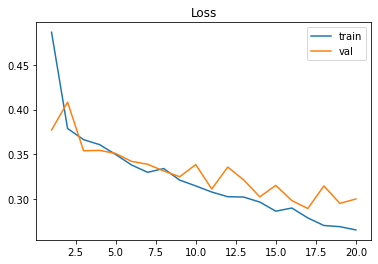

In [ ]:
epochs = range(1, len(history_dict['loss']) + 1)
plt.title('Loss')
plt.plot(epochs, history_dict['loss'], label='train')
plt.plot(epochs, history_dict['val_loss'], label='val')
plt.legend()
plt.show();

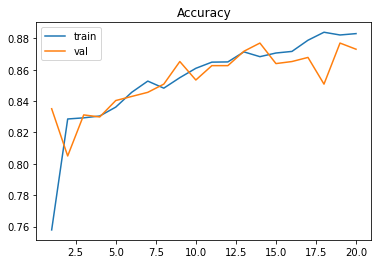

In [ ]:
plt.title('Accuracy')
plt.plot(epochs, history_dict['accuracy'], label='train')
plt.plot(epochs, history_dict['val_accuracy'], label='val')
plt.legend()
plt.show();

Finally, we can obtain our full training performance information, including class-level (Precision, Recall, F1). 

In [ ]:
preds_train = (nn_mod.predict(norm_x_train) > 0.5).astype("int32")

In [ ]:
print(classification_report(y_train, preds_train, digits=4))

              precision    recall  f1-score   support

           0     0.8122    0.9843    0.8900      3831
           1     0.9799    0.7708    0.8629      3804

    accuracy                         0.8779      7635
   macro avg     0.8961    0.8776    0.8764      7635
weighted avg     0.8958    0.8779    0.8765      7635



#### Visualizing the Network Architecture

We can summarize our NN and visualize the network architecture to better understand the network before obtaining model performance information on our testing set.

In [ ]:
nn_mod.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_Layer_1 (Dense)      (None, 100)               1800      
                                                                 
 Hidden_Layer_2 (Dense)      (None, 64)                6464      
                                                                 
 Hidden_Layer_3 (Dense)      (None, 48)                3120      
                                                                 
 Hidden_Layer_4 (Dense)      (None, 36)                1764      
                                                                 
 Hidden_Layer_5 (Dense)      (None, 20)                740       
                                                                 
 Hidden_Layer_6 (Dense)      (None, 10)                210       
                                                                 
 Output_Layer (Dense)        (None, 1)                 1

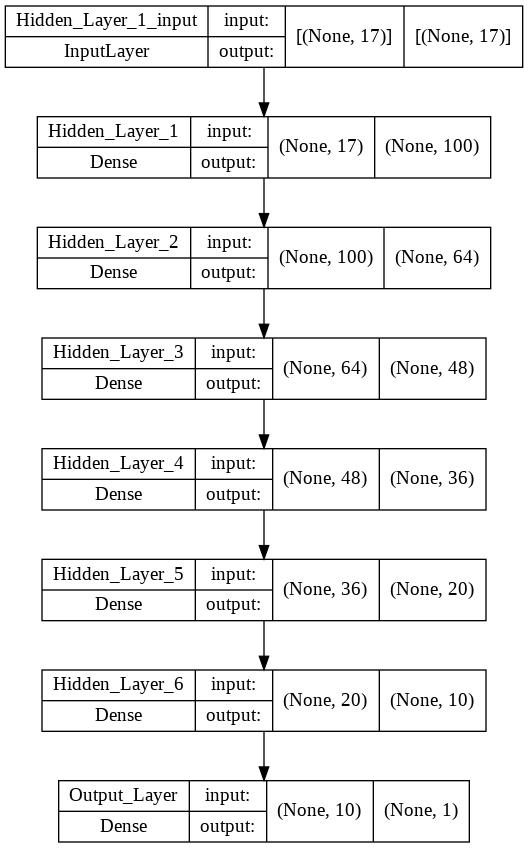

In [ ]:
plot_model(nn_mod, show_shapes=True, show_layer_names=True)

#### Model Testing

Finally, we obtain predictions and performance information on our testing set, using range normalize input variables.

In [ ]:
norm_x_test = range_scaler.transform(x_test)

In [ ]:
preds_test = (nn_mod.predict(norm_x_test) > 0.5).astype("int32")
print(classification_report(y_test, preds_test, digits=6))

              precision    recall  f1-score   support

           0   0.814488  0.979809  0.889532       941
           1   0.975547  0.783058  0.868768       968

    accuracy                       0.880042      1909
   macro avg   0.895017  0.881433  0.879150      1909
weighted avg   0.896156  0.880042  0.879003      1909



## Model Tuning

Model choices that can impact your model's performance include:
- amount of data available for use in train/test/validation
- the number of layers
- the types of layers used
- the order of the layers

Some hyperparameters that can be tuned include:
- number of neurons (units) per layer
- number of layers
- optimization learning rate, decay rate
- batch size
- number of epochs

### Keras Tuner

**Keras Tuner** can be used for hyperparameter tuning. In the following example, we will tune the following model hyperparameters:
- Number of nodes per layer
- Optimization learning rate
- Number of Epochs

First, we install and import keras tuner. 

In [ ]:
pip install -q -U keras-tuner

     |████████████████████████████████| 135 kB 13.9 MB/s 
     |████████████████████████████████| 1.6 MB 61.8 MB/s 


In [ ]:
import keras_tuner as kt

We can create a function to define our sequential NN model and the grid space for our hyperparameters. We can use `hp.Int()` to create a sequence for our grid search or use `hp.Choice()` to explicitly provide the grid for the hyperparameter by name.

In the example below, we have a NN with 4 hidden layers, as in the previous example. Here, we are tuning the number of units for each of the layers and the learning rate.


In [ ]:
def model_builder(hp):
  model = keras.Sequential()
  # Tune the number of units in the first Dense layer
  # Choose an optimal value 
  hp_units1 = hp.Int('units_1', min_value = 16, 
                     max_value = 200, 
                     step = 16)
  hp_units2 = hp.Int('units_2', min_value = 16, 
                     max_value = 160, 
                     step = 16)
  hp_units3 = hp.Int('units_3', min_value = 16, 
                     max_value = 80, 
                     step = 16)
  hp_units4 = hp.Int('units_4', min_value = 16, 
                     max_value = 80, 
                     step = 16)
  hp_units5 = hp.Int('units_5', min_value = 16, 
                     max_value = 32, 
                     step = 8)
  hp_units6 = hp.Int('units_6', min_value = 8, 
                     max_value = 32, 
                     step = 4)
  model.add(Dense(units = hp_units1, 
                               activation = 'relu'))
  model.add(Dense(units = hp_units2, 
                               activation = 'relu'))
  model.add(Dense(units = hp_units3, 
                               activation = 'relu'))
  model.add(Dense(units = hp_units4, 
                               activation = 'relu'))
  model.add(Dense(units = hp_units5, 
                               activation = 'relu'))
  model.add(Dense(units = hp_units6, 
                               activation = 'relu'))
  model.add(Dense(units = 1,
              activation = 'sigmoid'))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.1 - 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-1, 1e-2, 1e-3, 1e-4])

  model.compile(optimizer = Adam(learning_rate = hp_learning_rate),
                loss = 'binary_crossentropy',
                metrics = 'accuracy')

  return model

Below, we use a variation of the [Hyperband](https://jmlr.org/papers/volume18/16-558/16-558.pdf) approach to optimizing hyperparameters. Other tuner options include `Tuner()`, `RandomSearch()`, and `BayesianOptimization()`.

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy',
                     max_epochs = 20,
                     factor = 3,
                     seed = 831,
                     directory = 'my_dir',
                     project_name = 'intro_to_kt3')

We use `EarlyStopping()` to help us choose a good number for the number of epochs and avoid overfitting the model or training the model with little improvement in loss minimization. We seek to optimize the validation loss (`monitor = 'val_loss'`) and set `patience = 5` to terminate training if after 5 epochs we have not improved our solution.

In [ ]:
stop_early = EarlyStopping(monitor = 'val_loss', patience = 5)

Finally, we conduct the hyperparameter search using `search()` and obtain as output the value of the highest validation accuracy.

In [ ]:
tuner.search(norm_x_train, 
             y_train, 
             epochs = 20, 
             batch_size = 32, 
             validation_split = 0.1, 
             callbacks = [stop_early])

Trial 30 Complete [00h 00m 06s]
val_accuracy: 0.5104712247848511

Best val_accuracy So Far: 0.8821989297866821
Total elapsed time: 00h 02m 41s


Next, we can get the values of our optimal hyperparameters, as well as an overview of the default values for each hyperparameter and the grid space that we searched over.

In [ ]:
best_mod = tuner.get_best_hyperparameters(num_trials = 1)[0]
best_mod.get_config()

{'space': [{'class_name': 'Int',
   'config': {'name': 'units_1',
    'default': None,
    'conditions': [],
    'min_value': 16,
    'max_value': 200,
    'step': 16,
    'sampling': None}},
  {'class_name': 'Int',
   'config': {'name': 'units_2',
    'default': None,
    'conditions': [],
    'min_value': 16,
    'max_value': 160,
    'step': 16,
    'sampling': None}},
  {'class_name': 'Int',
   'config': {'name': 'units_3',
    'default': None,
    'conditions': [],
    'min_value': 16,
    'max_value': 80,
    'step': 16,
    'sampling': None}},
  {'class_name': 'Int',
   'config': {'name': 'units_4',
    'default': None,
    'conditions': [],
    'min_value': 16,
    'max_value': 80,
    'step': 16,
    'sampling': None}},
  {'class_name': 'Int',
   'config': {'name': 'units_5',
    'default': None,
    'conditions': [],
    'min_value': 16,
    'max_value': 32,
    'step': 8,
    'sampling': None}},
  {'class_name': 'Int',
   'config': {'name': 'units_6',
    'default': None,
  

Finally, we can run the model using our optimal hyperparameters.

In [ ]:
model_tune = tuner.hypermodel.build(best_mod)
history_tune = model_tune.fit(norm_x_train, 
                              y_train,
                              epochs = best_mod.get('tuner/epochs'),
                              batch_size = 32,
                              validation_split = 0.1)

Epoch 1/20
215/215 [==============================] - 1s 3ms/step - loss: 0.4995 - accuracy: 0.7526 - val_loss: 0.3805 - val_accuracy: 0.8181
Epoch 2/20
215/215 [==============================] - 0s 2ms/step - loss: 0.3744 - accuracy: 0.8229 - val_loss: 0.3607 - val_accuracy: 0.8325
Epoch 3/20
215/215 [==============================] - 0s 2ms/step - loss: 0.3620 - accuracy: 0.8338 - val_loss: 0.3488 - val_accuracy: 0.8429
Epoch 4/20
215/215 [==============================] - 0s 2ms/step - loss: 0.3485 - accuracy: 0.8409 - val_loss: 0.3363 - val_accuracy: 0.8469
Epoch 5/20
215/215 [==============================] - 1s 2ms/step - loss: 0.3465 - accuracy: 0.8382 - val_loss: 0.3546 - val_accuracy: 0.8482
Epoch 6/20
215/215 [==============================] - 0s 2ms/step - loss: 0.3331 - accuracy: 0.8507 - val_loss: 0.3511 - val_accuracy: 0.8469
Epoch 7/20
215/215 [==============================] - 1s 2ms/step - loss: 0.3237 - accuracy: 0.8539 - val_loss: 0.3541 - val_accuracy: 0.8403
Epoch 

In [ ]:
preds_train_tune = (model_tune.predict(norm_x_train) > 0.5).astype("int32")
print(classification_report(y_train, preds_train_tune, digits = 6))

              precision    recall  f1-score   support

           0   0.860202  0.954059  0.904703      3831
           1   0.948021  0.843849  0.892907      3804

    accuracy                       0.899149      7635
   macro avg   0.904112  0.898954  0.898805      7635
weighted avg   0.903957  0.899149  0.898826      7635



In [ ]:
preds_test_tune = (model_tune.predict(norm_x_test) > 0.5).astype("int32")
print(classification_report(y_test, preds_test_tune, digits = 6))

              precision    recall  f1-score   support

           0   0.852998  0.937301  0.893165       941
           1   0.932571  0.842975  0.885513       968

    accuracy                       0.889471      1909
   macro avg   0.892785  0.890138  0.889339      1909
weighted avg   0.893347  0.889471  0.889285      1909



Kappa value

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix



In [ ]:
def get_kappa_binary(actual_y, pred_y):
    cm = confusion_matrix(actual_y, pred_y)
    total = sum(sum(cm))
    p_expected_c0 = ((cm[0,0]+cm[0,1])/total) * ((cm[0,0]+cm[1,0])/total)
    p_expected_c1 = ((cm[1,1]+cm[1,0])/total) * ((cm[1,1]+cm[0,1])/total)
    p_expected = p_expected_c0 + p_expected_c1
    p_actual = (cm[0,0]+cm[1,1])/total
    kappa = (p_actual - p_expected)/(1 - p_expected)
    return kappa

In [ ]:
get_kappa_binary(y_train, preds_train_tune)

0.7982166580481553

In [ ]:
get_kappa_binary(y_test, preds_test_tune)

0.7792019567096625

In [ ]:
# For binary_classification

def get_performance_binary(actual_Y, pred_Y):
  cm = confusion_matrix(actual_Y, pred_Y)
  total = sum(sum(cm))
  sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
  specificity = cm[1,1]/(cm[1,0]+cm[1,1])
  return sensitivity, specificity

In [ ]:
get_performance_binary(y_train, preds_train_tune)

(0.9540589924301749, 0.8438485804416404)

In [ ]:
get_performance_binary(y_test, preds_test_tune)

(0.9373007438894793, 0.8429752066115702)

## Additional Model Considerations

> Indented block



### Imbalanced Data
In the presence of class imbalance, common approaches include:
- resampling (ie random oversampling, random undersampling, SMOTE)
- alternate performance metrics (precision, recall, F1, AUC/ROC)
- initialize class weights

For more information, visit: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data

### Overfitting

In the presence of overfitting, common approaches include:
- train using more data
- decreasing model capacity
- dropout
- weight regularization

Decreasing model capacity involves reducing the number of model parameters. 

**Regularization**, specifically **dropout** can be used. You can add `Dropout()` as you would layers in the model and can be added between layers so that the model does not learn spurious features at hidden nodes. A common dropout rate is 0.5. 

You can also add weight regularization (L1 or L2) to layers through the `kernel_regularizer` argument. **Weight regularization** put constraints on the complexity of a network by forcing its weights only to take small values, which makes the distribution of weight values more "regular".

For more information, visit: https://www.tensorflow.org/tutorials/keras/overfit_and_underfit